# Demo the Arbitrageur Agent Logic

This notebook:

1. Fetches the latest crvusd contract data into Python objects using `crvusdsim`.
2. Fetches prices and `ExternalMarket`s from the `baseline` scenario.
3. Instantiates an Arbitrageur agent.
4. Checks if there are profitable arbitrages and performs them.

TODO describe the arbitrage logic in detail.

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.sim.scenario import Scenario

In [2]:
# Generate markets and prices
scenario = Scenario("baseline")
sample = scenario.pricepaths[0]
scenario.prepare_for_run() # Set block timestamps
scenario.prepare_for_trades(sample) # Set External Market Price

# Unpack
markets = scenario.markets
pool = scenario.llamma
stableswap_pools = scenario.stableswap_pools
cycles = scenario.cycles
arbitrageur = scenario.arbitrageur

# Display available arbitrage cycles
cycles

[DEBUG][17:06:34][root]-762677: Using 614880 1Inch quotes.
[INFO][17:06:34][root]-762677: Fetching sim_market from subgraph.
[INFO][17:06:40][root]-762677: Found 20 valid cycles of length 3.


[Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDP, in=crvUSD, out=USDP, amt=0), Swap(pool=External Market (TUSD, USDP), in=Pax Dollar, out=TrueUSD, amt=0)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=crvUSD, out=USDC, amt=0), Swap(pool=External Market (TUSD, USDC), in=USD Coin, out=TrueUSD, amt=0)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=0), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDT, in=crvUSD, out=USDT, amt=0), Swap(pool=External Market (TUSD, USDT), in=Tether USD, out=TrueUSD, amt=0)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=crvUSD, amt=0), Swap(pool=Curve.fi Stablecoin WETH, in=crvUSD, out=WETH, amt=0), Swa

# Show that arbitrage cycle optimization finds the most profitable arbitrage

The `cycle.optimize()` method will find the `amt_in` to the first trade in a `Cycle` that maximizes the `Cycle`'s profit. We plot `cycle.optimize()` against the profits from a simple `np.linspace` to show it converges to the maximum. The dataframe below also tells the same story.

In [3]:
df = pd.DataFrame(
    columns=["amt_optimize", "amt_linspace", "profit_optimize", "profit_linspace"]
)

for i, cycle in enumerate(cycles):
    try:
        # This is orders of magnitude slower than `optimize`
        trade = cycle.trades[0]
        high = trade.pool.get_max_trade_size(trade.i, trade.j)
        amts = np.linspace(0, high, 1000)
        amts = [int(amt) for amt in amts]
        profits = [cycle.populate(amt) for amt in amts]

        best_amt_linspace = int(amts[np.argmax(profits)])
        best_profit_linspace = int(max(profits))

        cycle.optimize()

        df.loc[i] = [
            cycle.trades[0].amt,
            best_amt_linspace,
            cycle.expected_profit,
            best_profit_linspace,
        ]

    except Exception as e:
        logging.error(f"Cycle {i} failed to optimize: {e}")

df["profit_linspace"] = df["profit_linspace"].astype(float)
df["profit_optimize"] = df["profit_optimize"].astype(float)
df = df.round(3)
df

,amt_optimize,amt_linspace,profit_optimize,profit_linspace
0,82.0,0.0,-0.000,0.0
1,184479794632915.0,0.0,-0.000,0.0
2,45126622800391.0,0.0,-0.000,0.0
3,672973294883689134555136,602774209723318484860928,12625.806,12791.0
4,283741420548363254759424,282614659574296936972288,730.735,729.0
5,705536708478318.0,0.0,-0.000,0.0
6,954922707858237.0,0.0,-0.000,0.0
7,564336975153790434934784,561304115543395293724672,14051.222,14025.0
8,521452924982.0,529078246704.0,1514.429,1513.0
9,513486620.0,0.0,0.128,0.0


Best amount linspace: 282614659574296936972288
Best profit linspace: 729.6619300769748
Best amount optimize: 283741420548363254759424
Best profit optimize: 730.7348808893317


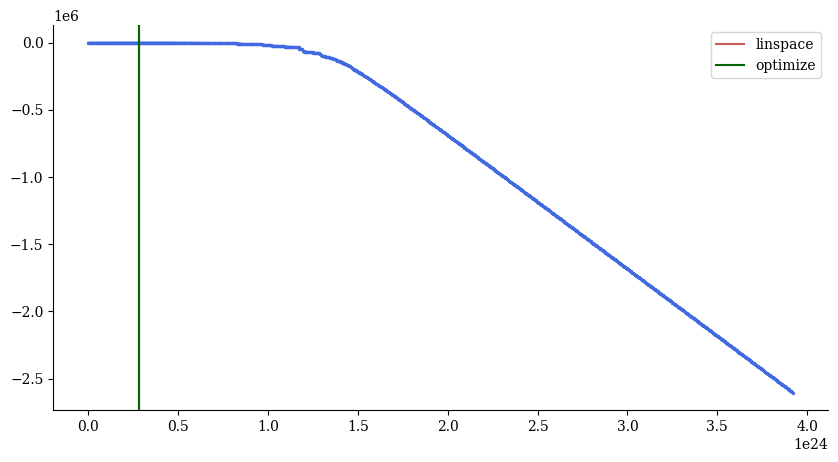

In [4]:
# TODO In theory, this curve should be perfectly smooth and convex.
# However, it has a few bumps. These bumps don't detract from the 
# convexity, but they do make it less smooth. The reason is that
# the slippage curves we set for `ExternalMarket`s are not perfectly 
# smooth: they have small regions where slippage is constant despite
# increasing trade size. We discuss this more in `demo_slippage_curves.ipynb`,
# but it has to do with the fact that we use an IsotonicRegression to
# fit the slippage curve, whereas the "true" relationship is moreso a 
# CenteredIsotonicRegression. This is a known issue, and we are working on it.

i = 4
cycle = cycles[i]

trade = cycle.trades[0]
high = trade.pool.get_max_trade_size(trade.i, trade.j)
amts = np.linspace(1, high, 1000)
amts = [int(amt) for amt in amts]
profits = [cycle.populate(amt) for amt in amts]

best_amt_linspace = amts[np.argmax(profits)]
best_profit_linspace = max(profits)

# compare
cycle.optimize()
best_amt_optimize = cycle.trades[0].amt
best_profit_optimize = cycle.expected_profit

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(amts, profits, color="royalblue", s=2)
ax.plot(amts, profits, color="royalblue")
ax.axvline(best_amt_linspace, color="indianred", label="linspace")
ax.axvline(best_amt_optimize, color="darkgreen", label="optimize")

# NOTE Uncomment to zoom into optimal region
# diff = abs(best_amt_optimize - best_amt_linspace)
# xlims = (float(min(best_amt_optimize, best_amt_linspace) - diff), float(max(best_amt_optimize, best_amt_linspace) + diff))
# tmp = [p for p, a in zip(profits, amts) if xlims[0] < a < xlims[1]]
# ylims = min(tmp), max(tmp)
# ax.set_xlim(*xlims)
# ax.set_ylim(*ylims)

ax.legend()

print(f"Best amount linspace: {best_amt_linspace}")
print(f"Best profit linspace: {best_profit_linspace}")
print(f"Best amount optimize: {best_amt_optimize}")
print(f"Best profit optimize: {best_profit_optimize}")

# Analyzing arbitrages

Now we show our arbitrage agent arbitraging all pools until there is no profitable arbitrage left.

In [5]:
profit, count = arbitrageur.arbitrage(cycles, sample)
print(f"Performed {count} arbitrages for a profit of {profit} USD.")

[INFO][17:06:47][root]-762677: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=crvUSD, amt=886531593712), Swap(pool=Curve.fi Stablecoin WETH, in=crvUSD, out=WETH, amt=890048458134603583222126), Swap(pool=External Market (USDC, WETH), in=Wrapped Ether, out=USD Coin, amt=405614537639519774036)], Expected Profit: 19388.241922).
[INFO][17:06:47][root]-762677: Executing trade Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=crvUSD, amt=886531593712).
[INFO][17:06:47][root]-762677: Executing trade Swap(pool=Curve.fi Stablecoin WETH, in=crvUSD, out=WETH, amt=890048458134603583222126).
[INFO][17:06:47][root]-762677: Executing trade Swap(pool=External Market (USDC, WETH), in=Wrapped Ether, out=USD Coin, amt=405614537639519774036).
[INFO][17:06:48][root]-762677: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=crvUSD, amt=466644094980), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD

(20532.688369684387, 5)